<a href="https://www.kaggle.com/code/uzairrj/human-disease-diagnosis-autoencoder-97-acc?scriptVersionId=163437621" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.nn import Linear, functional as Func, Module,ModuleList
from plotly import express as exp, graph_objs as go
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,Dataset
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/kaggle/input/human-disease-dataset/Training.csv")
df_test = pd.read_csv("/kaggle/input/human-disease-dataset/Testing.csv")

In [3]:
df = df.drop(["Unnamed: 133"],axis=1)

In [4]:
df.shape

(4920, 133)

In [5]:
df_test.shape

(42, 133)

In [6]:
prog_counts = df.prognosis.value_counts()
exp.pie(values=prog_counts.values,names=prog_counts.keys())

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_obj = le.fit(df.prognosis)
df.prognosis = le_obj.transform(df.prognosis)
df_test.prognosis = le_obj.transform(df_test.prognosis)

# Validation Split

In [8]:
train_X, val_X, train_Y, val_Y = train_test_split(df[df.columns[:-1]],df[df.columns[-1]],test_size=0.2, random_state=123,stratify=df[df.columns[-1]])

# Autoencoder

In [9]:
class DiseaseAutoEncoder(Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = ModuleList([
            Linear(132,64),
            Linear(64,32),
        ])
        
        self.z = ModuleList([
            Linear(32,16),
            Linear(16,32)
        ])
        
        self.decoder = ModuleList([
            Linear(32,64),
            Linear(64,132)
        ])
        
        self.linearClassification = ModuleList([
            Linear(16,32),
            Linear(32,24),
            Linear(24,41)
        ])
        
    def Freeze(self):
        for e in self.encoder:
            for parm in e.parameters():
                parm.requires_grad = False
            
        self.z[0].weight.requires_grad = False
        self.z[0].bias.requires_grad = False
        
    def ForwardClassification(self, batch):
        x = batch
        self.Freeze()
        for e in self.encoder:
            x = e(x)
            x = Func.relu(x)
        
        x=self.z[0](x)
        x = Func.relu(x)
        
        for l in self.linearClassification[:-1]:
            x = l(x)
            x = Func.relu(x)
        x = self.linearClassification[-1](x)
        return Func.softmax(x,dim=0)
        
    def Forward(self, batch):        
        x = batch
        for e in self.encoder:
            x = e(x)
            x = Func.relu(x)
            
        x = self.z[0](x)
        x = Func.relu(x)
        x = self.z[1](x)
        x = Func.relu(x)
            
        for d in self.decoder[:-1]:
            x = d(x)
            x = Func.relu(x)
                
        x = self.decoder[-1](x)
        x = Func.sigmoid(x)
        return x

In [10]:
class DiseaseDataset(Dataset):
    def __init__(self, X,Y):
        super().__init__()
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self,idx):
        return torch.tensor(self.X.iloc[idx].values,dtype=torch.float32),torch.tensor(self.Y.iloc[idx],dtype=torch.long)

In [11]:
device = "cpu" if not torch.cuda.is_available() else "cuda:0"
model = DiseaseAutoEncoder()
model = model.to(device)

In [12]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

In [13]:
disease_dataloader = DataLoader(DiseaseDataset(train_X, train_Y), batch_size=128,shuffle=True,num_workers=0)
disease_val_dataloader = DataLoader(DiseaseDataset(val_X, val_Y), batch_size=len(val_X),shuffle=True,num_workers=0)

In [14]:
epochs = 100
pbar = tqdm(range(epochs))
total_batches = len(disease_dataloader)
history = {"Loss": [], "Val Loss": []}
for i in pbar:
    running_loss = 0
    for batch,Y in disease_dataloader:
        batch = batch.to(device)
        optim.zero_grad()
        out = model.Forward(batch)
        loss = criterion(out, batch)
        loss.backward()
        optim.step()
        running_loss += loss
    val_batch,val_Y = next(iter(disease_val_dataloader))
    val_batch, val_Y = val_batch.to(device), val_Y.to(device)
    val_loss = criterion(model.Forward(val_batch),val_batch)
    history["Loss"].append((running_loss/total_batches).item())
    history["Val Loss"].append(val_loss.item())
    pbar.set_postfix_str(f"Loss: {running_loss/total_batches:.4f}, Val Loss: {val_loss:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
fig = go.Figure()

x_axis = [i for i in range(1,epochs+1)]

fig.add_trace(go.Scatter(mode='lines',x=x_axis,y=history["Loss"], name="Loss"))
fig.add_trace(go.Scatter(mode='lines',x=x_axis,y=history["Val Loss"], name="Val Loss"))

fig.update_layout(
    title="Autoencoder training losses",
    xaxis_title="Epochs",
    yaxis_title="Loss"
)

In [16]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [17]:
epochs = 100
pbar = tqdm(range(epochs))
total_batches = len(disease_dataloader)
history = {"Loss": [], "Val Loss": [],"Accuracy": [], "Val Accuracy": []}
for i in pbar:
    running_loss = 0
    accuracy = 0
    total_samples = 0
    for batch,Y in disease_dataloader:
        batch, Y = batch.to(device), Y.to(device)
        optim.zero_grad()
        out = model.ForwardClassification(batch)
        loss = criterion(out, Y)
        loss.backward()
        optim.step()
        accuracy += (torch.max(out,1)[1] == Y).sum().item()
        total_samples += Y.size(0)
        running_loss += loss
    val_batch,val_Y = next(iter(disease_val_dataloader))
    val_batch, val_Y = val_batch.to(device), val_Y.to(device)
    out = model.ForwardClassification(val_batch)
    loss = criterion(out, val_Y)
    history["Loss"].append((running_loss/total_batches).item())
    history["Val Loss"].append(loss.item())
    history["Accuracy"].append((accuracy/total_samples))
    predicted_labels = torch.max(out,1)[1]
    history["Val Accuracy"].append(((predicted_labels == val_Y).sum()/val_Y.size(0)).item())
    pbar.set_postfix_str(f"Loss: {running_loss/total_batches:.4f}, Val Loss: {loss:.4f}, Accuracy: {accuracy/total_samples:.4f}, Val Accuracy: {(predicted_labels == val_Y).sum()/val_Y.size(0):.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
fig = go.Figure()

x_axis = [i for i in range(1,epochs+1)]

fig.add_trace(go.Scatter(mode='lines',x=x_axis,y=history["Loss"], name="Loss"))
fig.add_trace(go.Scatter(mode='lines',x=x_axis,y=history["Val Loss"], name="Val Loss"))

fig.update_layout(
    title="Classifier training losses",
    xaxis_title="Epochs",
    yaxis_title="Loss"
)

In [19]:
fig = go.Figure()

x_axis = [i for i in range(1,epochs+1)]

fig.add_trace(go.Scatter(mode='lines',x=x_axis,y=history["Accuracy"], name="Accuracy"))
fig.add_trace(go.Scatter(mode='lines',x=x_axis,y=history["Val Accuracy"], name="Val Accuracy"))

fig.update_layout(
    title="Classifier training accuracies",
    xaxis_title="Epochs",
    yaxis_title="Loss"
)

# Testing Model

In [20]:
disease_test_dataloader = DataLoader(DiseaseDataset(df_test[df_test.columns[:-1]], df_test[df_test.columns[-1]]), batch_size=len(df_test[df_test.columns[-1]]))

In [21]:
test_X, test_Y = next(iter(disease_test_dataloader))
test_X, test_Y = test_X.to(device), test_Y.to(device)

out = model.ForwardClassification(test_X)
predicted_labels = torch.max(out,1)[1]
print(f"Accuracy: {(predicted_labels == test_Y).sum().item()/test_Y.size(0):.4f}")

Accuracy: 0.9762


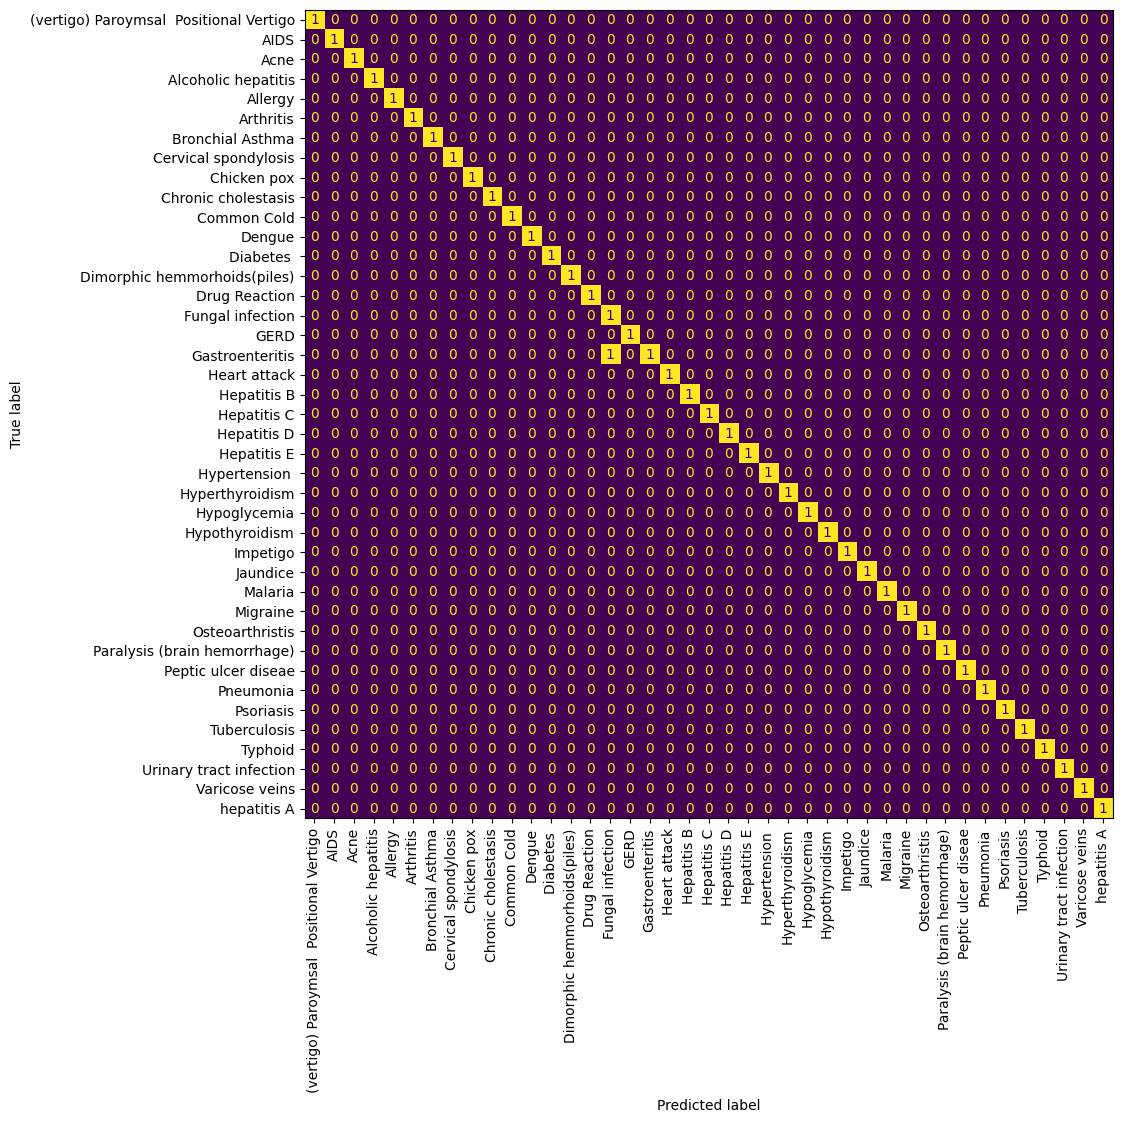

In [22]:
cm = confusion_matrix(predicted_labels.cpu(),test_Y.cpu())
disp = ConfusionMatrixDisplay(cm,display_labels=le_obj.classes_)
disp.plot(colorbar=False,xticks_rotation="vertical")
disp.figure_.set_size_inches(18.5, 10.5)
plt.show()